In [1]:
#%reset

In [2]:
import pandas as pd
import numpy as np
import os

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score 
from sklearn.metrics import precision_recall_fscore_support, classification_report

import matplotlib.pyplot as plt
%matplotlib inline

import functools

import h5py

In [3]:
P_THRESHOLD=0.5

### Which data

In [4]:
DATADIR = os.getenv('DATADIR')

In [5]:
print("model v2.0.0 was run on data dated {}".format(DATADIR))

model v2.0.0 was run on data dated /data/2018-03-27


### Get full content to enable total counts

In [6]:
full_content = pd.read_csv(
    os.path.join(DATADIR, 'full_content.csv.gz'),
    dtype=object,
    compression='gzip'
)

In [7]:
full_content.shape

(210154, 26)

In [8]:
full_content.columns

Index(['base_path', 'content_id', 'content_purpose_document_supertype',
       'content_purpose_subgroup', 'content_purpose_supergroup', 'description',
       'details', 'document_type', 'email_document_supertype',
       'first_published_at', 'government_document_supertype', 'locale',
       'navigation_document_supertype', 'public_updated_at', 'publishing_app',
       'publishing_scheduled_at', 'scheduled_publishing_delay_seconds',
       'search_user_need_document_supertype', 'title', 'updated_at',
       'user_journey_document_supertype', 'document_type_gp', 'taxons',
       'primary_publishing_organisation', 'body', 'combined_text'],
      dtype='object')

In [9]:
full_content.content_id.nunique()

210154

In [10]:
unlabelled_meta = pd.read_csv(
    os.path.join(DATADIR, 'unlabelled_predictions_meta.csv.gz'),
    dtype=object,
    compression='gzip'
)

In [11]:
unlabelled_meta.shape

(19069776, 17)

In [12]:
unlabelled_meta.content_id.nunique()

85434

In [13]:
labelled_level2 = pd.read_csv(
    os.path.join(DATADIR, 'labelled_level2.csv.gz'),
    dtype=object,
    compression='gzip'
)

labelled_level2.shape

(181209, 33)

In [14]:
labelled_level2.taxon_id.nunique()

2690

In [15]:
labelled_level2.content_id.nunique()

130208

## Analyses
### count content items

In [16]:
unlabelled_meta.groupby(['prob_cat']).content_id.nunique()

prob_cat
0.01-0.09    59791
0.1-0.19     32389
0.2-0.29     21769
0.3-0.39     16252
0.4-0.49     12508
0.5-0.59      9719
0.6-0.69      8618
0.7-0.79      8657
<0.01        85433
>=0.8        51437
Name: content_id, dtype: int64

In [17]:
unlabelled_meta.groupby('untagged_type')['content_id'].nunique()

untagged_type
level1only    17388
old_taxons       41
untagged      68008
Name: content_id, dtype: int64

### predict taxon at 50%

In [18]:
unlabelled_meta['prob'] = pd.to_numeric(unlabelled_meta['prob'])
predictions = unlabelled_meta[unlabelled_meta['prob'] > 0.5]

In [19]:
print("{} out of {} ({}%) unlabelled content items were tagged at 50%".format(
    predictions.content_id.nunique(),
    unlabelled_meta.content_id.nunique(),
    predictions.content_id.nunique()/unlabelled_meta.content_id.nunique()*100))

66270 out of 85434 (77.56864948381207%) unlabelled content items were tagged at 50%


In [20]:
print("There would be a residual {} items that are hard-to-tag".format(
    unlabelled_meta.content_id.nunique() - predictions.content_id.nunique()))

There would be a residual 19164 items that are hard-to-tag


In [21]:
predictions.groupby('untagged_type')['content_id'].nunique()

untagged_type
level1only    12965
old_taxons       39
untagged      53269
Name: content_id, dtype: int64

In [22]:
print("the total number of items tagged to level 2 or lower would be {}".format(
labelled_level2.content_id.nunique() + predictions.content_id.nunique() ))

the total number of items tagged to level 2 or lower would be 196478


In [23]:
print("{} items would be tagged to level 2 or lower out of {} ({}%) in-scope items".format(
labelled_level2.content_id.nunique() + predictions.content_id.nunique(), 
full_content.content_id.nunique(),
(labelled_level2.content_id.nunique() + predictions.content_id.nunique())/full_content.content_id.nunique() * 100
))

196478 items would be tagged to level 2 or lower out of 210154 (93.49239129400344%) in-scope items


In [24]:
print("the ML would have tagged {}  out of {} ({}%) in-scope items".format(
predictions.content_id.nunique(), 
full_content.content_id.nunique(),
predictions.content_id.nunique()/full_content.content_id.nunique() * 100
))

the ML would have tagged 66270  out of 210154 (31.534017910675026%) in-scope items


In [25]:
full_content.content_id.nunique()

210154

### constrain predictions to well-performng taxons

those with an F1 score of at least 0.8

In [26]:
dev_metrics = pd.read_csv(
    os.path.join(DATADIR, "dev_metrics.csv.gz"),
    dtype=object,
    compression='gzip'
)

In [27]:
dev_metrics['f1'] = pd.to_numeric(dev_metrics['f1'])

In [28]:
good_taxons = dev_metrics[dev_metrics['f1']>=0.8]['taxon2label']

In [29]:
lowrisk_predictions = predictions.loc[predictions['taxon2label'].isin(good_taxons)]

In [30]:
lowrisk_predictions.shape

(60329, 17)

In [31]:
print("{} out of {} ({}%) items tagged at 50% to low risk taxons".format(
      lowrisk_predictions.content_id.nunique(),
      unlabelled_meta.content_id.nunique(),
      lowrisk_predictions.content_id.nunique()/unlabelled_meta.content_id.nunique()*100))

50670 out of 85434 (59.30894023456703%) items tagged at 50% to low risk taxons


In [32]:
print("{} items would be tagged to level 2 or lower out of {} ({}%) in-scope items".format(
labelled_level2.content_id.nunique() + lowrisk_predictions.content_id.nunique(), 
full_content.content_id.nunique(),
(labelled_level2.content_id.nunique() + lowrisk_predictions.content_id.nunique())/full_content.content_id.nunique() * 100
))

180878 items would be tagged to level 2 or lower out of 210154 (86.06926349248646%) in-scope items


In [33]:
print("the ML would have tagged {}  out of {} ({}%) in-scope items".format(
lowrisk_predictions.content_id.nunique(), 
full_content.content_id.nunique(),
lowrisk_predictions.content_id.nunique()/full_content.content_id.nunique() * 100
))

the ML would have tagged 50670  out of 210154 (24.110890109158046%) in-scope items


In [34]:
print("There would be a residual {} items that are hard-to-tag".format(
    unlabelled_meta.content_id.nunique() - lowrisk_predictions.content_id.nunique()))

There would be a residual 34764 items that are hard-to-tag


### UK economy only

exclude UK economy but keep others, based on content strategists' appraisal of predcitions

In [35]:
no_uk_economy = predictions.loc[predictions['taxon2label'] != 'UK economy']

In [36]:
print("{} out of {} ({}%) items tagged at 50% excluding UK economy".format(
      no_uk_economy.content_id.nunique(),
      unlabelled_meta.content_id.nunique(),
      no_uk_economy.content_id.nunique()/unlabelled_meta.content_id.nunique()*100))

64438 out of 85434 (75.42430414120842%) items tagged at 50% excluding UK economy


In [37]:
print("{} items would be tagged to level 2 or lower out of {} ({}%) in-scope items".format(
labelled_level2.content_id.nunique() + no_uk_economy.content_id.nunique(), 
full_content.content_id.nunique(),
(labelled_level2.content_id.nunique() + no_uk_economy.content_id.nunique())/full_content.content_id.nunique() * 100
))

194646 items would be tagged to level 2 or lower out of 210154 (92.62064961885093%) in-scope items


In [38]:
print("There would be a residual {} items that are hard-to-tag".format(
    unlabelled_meta.content_id.nunique() - no_uk_economy.content_id.nunique()))

There would be a residual 20996 items that are hard-to-tag


In [39]:
print("the ML would have tagged {}  out of {} ({}%) in-scope items".format(
no_uk_economy.content_id.nunique(), 
full_content.content_id.nunique(),
no_uk_economy.content_id.nunique()/full_content.content_id.nunique() * 100
))

the ML would have tagged 64438  out of 210154 (30.662276235522523%) in-scope items


### hard to tag (UK economy)

In [40]:
no_uk_economy_reduced = no_uk_economy[['content_id', 'base_path']].copy()

In [41]:
hard_to_tag = pd.merge(
    left=no_uk_economy_reduced,
    right=unlabelled_meta,
    on='content_id',
    how='outer',
    indicator=True
)

In [42]:
hard_to_tag.groupby('_merge').size()

_merge
left_only            0
right_only     4744224
both          21834360
dtype: int64

In [43]:
hard_to_tag[hard_to_tag['_merge']=='right_only']

,content_id,base_path_x,prob,taxon2label,base_path_y,description,document_type,document_type_gp,first_published_at,level1taxon,locale,primary_publishing_organisation,publishing_app,taxon_id,title,untagged_type,updated_at,prob_cat,_merge
21834360,60320607-7631-11e4-a3cb-005056011aef,NaN,7.039967e-10,Administrative justice reform,/government/news/capacity-building-for-the-mac...,british embassy launches project support for t...,world_news_story,news_and_announcements,2014-11-17 19:13:56.000,NaN,en,NaN,whitehall,NaN,capacity building for the macedonian security ...,untagged,2017-08-24 16:27:39.284,<0.01,right_only
21834361,60320607-7631-11e4-a3cb-005056011aef,NaN,1.144122e-08,"Adoption, fostering and surrogacy",/government/news/capacity-building-for-the-mac...,british embassy launches project support for t...,world_news_story,news_and_announcements,2014-11-17 19:13:56.000,NaN,en,NaN,whitehall,NaN,capacity building for the macedonian security ...,untagged,2017-08-24 16:27:39.284,<0.01,right_only
21834362,60320607-7631-11e4-a3cb-005056011aef,NaN,7.909353e-07,Afghanistan,/government/news/capacity-building-for-the-mac...,british embassy launches project support for t...,world_news_story,news_and_announcements,2014-11-17 19:13:56.000,NaN,en,NaN,whitehall,NaN,capacity building for the macedonian security ...,untagged,2017-08-24 16:27:39.284,<0.01,right_only
21834363,60320607-7631-11e4-a3cb-005056011aef,NaN,6.987006e-06,Armed Forces Covenant,/government/news/capacity-building-for-the-mac...,british embassy launches project support for t...,world_news_story,news_and_announcements,2014-11-17 19:13:56.000,NaN,en,NaN,whitehall,NaN,capacity building for the macedonian security ...,untagged,2017-08-24 16:27:39.284,<0.01,right_only
21834364,60320607-7631-11e4-a3cb-005056011aef,NaN,6.374691e-10,Armed forces,/government/news/capacity-building-for-the-mac...,british embassy launches project support for t...,world_news_story,news_and_announcements,2014-11-17 19:13:56.000,NaN,en,NaN,whitehall,NaN,capacity building for the macedonian security ...,untagged,2017-08-24 16:27:39.284,<0.01,right_only
21834365,60320607-7631-11e4-a3cb-005056011aef,NaN,3.227462e-06,Armed forces and Ministry of Defence reform,/government/news/capacity-building-for-the-mac...,british embassy launches project support for t...,world_news_story,news_and_announcements,2014-11-17 19:13:56.000,NaN,en,NaN,whitehall,NaN,capacity building for the macedonian security ...,untagged,2017-08-24 16:27:39.284,<0.01,right_only
21834366,60320607-7631-11e4-a3cb-005056011aef,NaN,5.849790e-07,Armed forces support for activities in the UK,/government/news/capacity-building-for-the-mac...,british embassy launches project support for t...,world_news_story,news_and_announcements,2014-11-17 19:13:56.000,NaN,en,NaN,whitehall,NaN,capacity building for the macedonian security ...,untagged,2017-08-24 16:27:39.284,<0.01,right_only
21834367,60320607-7631-11e4-a3cb-005056011aef,NaN,5.486633e-02,Arts and culture,/government/news/capacity-building-for-the-mac...,british embassy launches project support for t...,world_news_story,news_and_announcements,2014-11-17 19:13:56.000,NaN,en,NaN,whitehall,NaN,capacity building for the macedonian security ...,untagged,2017-08-24 16:27:39.284,0.01-0.09,right_only
21834368,60320607-7631-11e4-a3cb-005056011aef,NaN,1.378083e-08,Assessing environmental impact,/government/news/capacity-building-for-the-mac...,british embassy launches project support for t...,world_news_story,news_and_announcements,2014-11-17 19:13:56.000,NaN,en,NaN,whitehall,NaN,capacity building for the macedonian security ...,untagged,2017-08-24 16:27:39.284,<0.01,right_only
21834369,60320607-7631-11e4-a3cb-005056011aef,NaN,2.225148e-08,Attorney General guidance to the legal profession,/government/news/capacity-building-for-the-mac...,british embassy launches project support for t...,world_news_story,news_and_announcements,2014-11-17 19:13:56.000,NaN,en,NaN,whitehall,NaN,capacity building for the macedonian s

In [45]:
no_uk_economy[no_uk_economy['document_type']=='guidance'].content_id.nunique()

4904

In [46]:
hard_to_tag = hard_to_tag[hard_to_tag['_merge']=='right_only']

In [48]:
hard_to_tag[hard_to_tag['document_type']=='guidance'].content_id.nunique()

1402

In [47]:
hard_to_tag.to_csv(os.path.join(DATADIR, 'hard_to_tag_ukeconomy.csv.gz'),compression='gzip',index=False)

### taxons with no content in dev set so F1=0

In [48]:
unknown_performance = dev_metrics[dev_metrics['f1']==0]['taxon2label']

In [49]:
highrisk_predictions = predictions.loc[predictions['taxon2label'].isin(unknown_performance)]

In [50]:
highrisk_predictions.shape

(42, 17)

In [51]:
highrisk_predictions.content_id.nunique()

42

In [53]:
highrisk_predictions[['taxon2label', 'title', 'description']]

,taxon2label,title,description
1860025,Byelaws,byelaws documents,key documents relating to byelaws.
1884305,Byelaws,byelaws: channel islands,this series brings together all documents rela...
1884454,Byelaws,byelaws: east anglia,this series brings together all documents rela...
1884640,Byelaws,byelaws: west midlands,this series brings together all documents rela...
1884654,Byelaws,byelaws: yorkshire and humberside,this series brings together all documents rela...
1884673,Byelaws,byelaws: wales,this series brings together all documents rela...
1884898,Byelaws,byelaws: south west,this series brings together all documents rela...
1884908,Byelaws,byelaws: greater london,this series brings together all documents rela...
1933675,Byelaws,byelaws: south east,this series brings together all documents rela...
5303696,End of life care,nhs outcomes framework 2013 to 2014,sets out the outcomes and corresponding indica...


In [76]:
predictions[predictions['title']=='nhs outcomes framework 2011 to 2012']

,content_id,prob,taxon2label,base_path,description,document_type,document_type_gp,first_published_at,level1taxon,locale,primary_publishing_organisation,publishing_app,taxon_id,title,untagged_type,updated_at,prob_cat
5305773,5d8b80cf-7631-11e4-a3cb-005056011aef,0.757068,End of life care,/government/publications/nhs-outcomes-framewor...,the nhs outcomes framework sets out indicators...,guidance,other,2010-12-20 00:00:00.000,NaN,en,Department of Health and Social Care,whitehall,NaN,nhs outcomes framework 2011 to 2012,untagged,2018-03-26 16:38:40.850,0.7-0.79
11662365,5d8b80cf-7631-11e4-a3cb-005056011aef,0.997986,National Health Service,/government/publications/nhs-outcomes-framewor...,the nhs outcomes framework sets out indicators...,guidance,other,2010-12-20 00:00:00.000,NaN,en,Department of Health and Social Care,whitehall,NaN,nhs outcomes framework 2011 to 2012,untagged,2018-03-26 16:38:40.850,>=0.8
13163227,5d8b80cf-7631-11e4-a3cb-005056011aef,0.899413,Public health,/government/publications/nhs-outcomes-framewor...,the nhs outcomes framework sets out indicators...,guidance,other,2010-12-20 00:00:00.000,NaN,en,Department of Health and Social Care,whitehall,NaN,nhs outcomes framework 2011 to 2012,untagged,2018-03-26 16:38:40.850,>=0.8
15282091,5d8b80cf-7631-11e4-a3cb-005056011aef,0.914091,Social care,/government/publications/nhs-outcomes-framewor...,the nhs outcomes framework sets out indicators...,guidance,other,2010-12-20 00:00:00.000,NaN,en,Department of Health and Social Care,whitehall,NaN,nhs outcomes framework 2011 to 2012,untagged,2018-03-26 16:38:40.850,>=0.8


In [54]:
highrisk_predictions[['base_path','taxon2label', 'title', 'description']].to_csv(os.path.join(DATADIR, 'zerof1predictions.csv.gz'),compression='gzip',index=False)

### taxons with 0.8>F1>0

In [55]:
dev_metrics[(dev_metrics['f1']<0.8) & (dev_metrics['f1']>0)]['taxon2label'].shape

(55,)

In [56]:
list(dev_metrics[(dev_metrics['f1']<0.8) & (dev_metrics['f1']>0)]['taxon2label'])

['Armed Forces Covenant',
 'Armed forces and Ministry of Defence reform',
 'Arts and culture',
 'Brexit',
 'British nationals overseas',
 'Business and the environment',
 'Careers in transport ',
 'Charities, volunteering and honours',
 'Civil service reform',
 'Coal',
 'Community and society',
 'Consumer rights and issues',
 'Counter-terrorism',
 'Countries (Living In)',
 'Dealing with HMRC',
 'Education of disadvantaged children',
 'Emergency preparation, response and recovery',
 'Environmental quality',
 'Equality, rights and citizenship',
 'Europe [PA] (Level 2 Government theme)',
 'European single market',
 'Financial services',
 'Government spending',
 'Health protection',
 'Heating and housing benefits',
 'Housing planning and building',
 'Human rights internationally',
 'Industrial strategy',
 'Inspections and performance of education providers',
 'Law and practice',
 'Local councils and services',
 'Local government',
 'Local government spending',
 'Local transport',
 'Localis

In [57]:
list(dev_metrics[dev_metrics['f1']==0]['taxon2label'])

['Byelaws',
 'Civil justice reform',
 'Content and publishing',
 'Devolution',
 'End of life care',
 'Medical certification and advice',
 'Public sector land use',
 'Public services',
 'Screening and quality assurance (all programmes)',
 'Secondments with government',
 'Sentencing reform',
 'Statutory rights']

In [58]:
atleast1pct = unlabelled_meta[unlabelled_meta['prob']>=0.01]
atleast1pct.shape

(766532, 17)

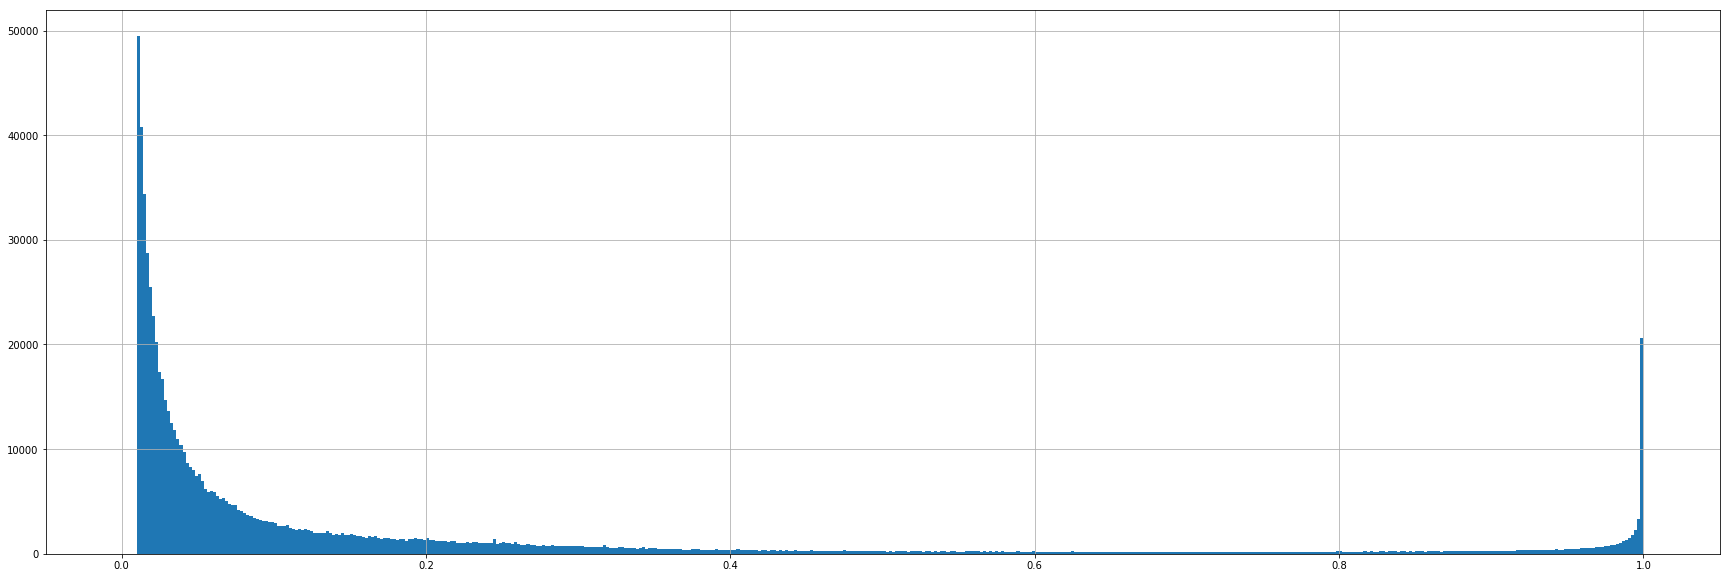

In [59]:
atleast1pct['prob'].hist(range=(0, 1), figsize=(30, 10), bins=500)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f31336a1ef0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f2f991e24e0>]], dtype=object)

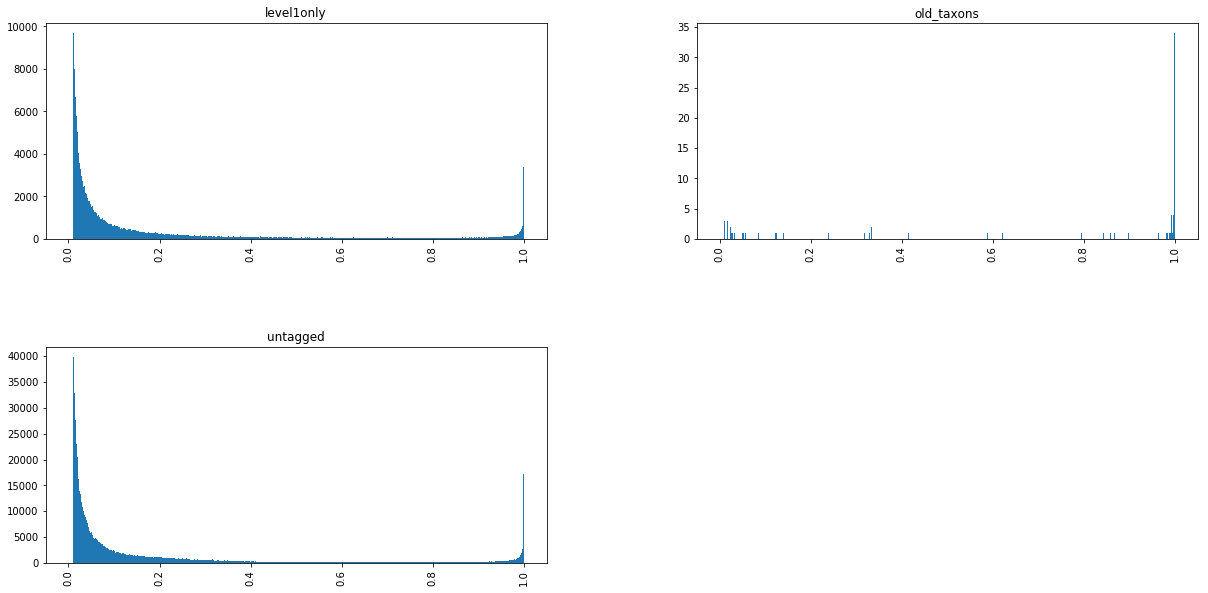

In [60]:
atleast1pct['prob'].hist(by=atleast1pct['untagged_type'], range=(0, 1), figsize=(20, 10), bins=500)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f32050ebf28>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f30206cc400>]], dtype=object)

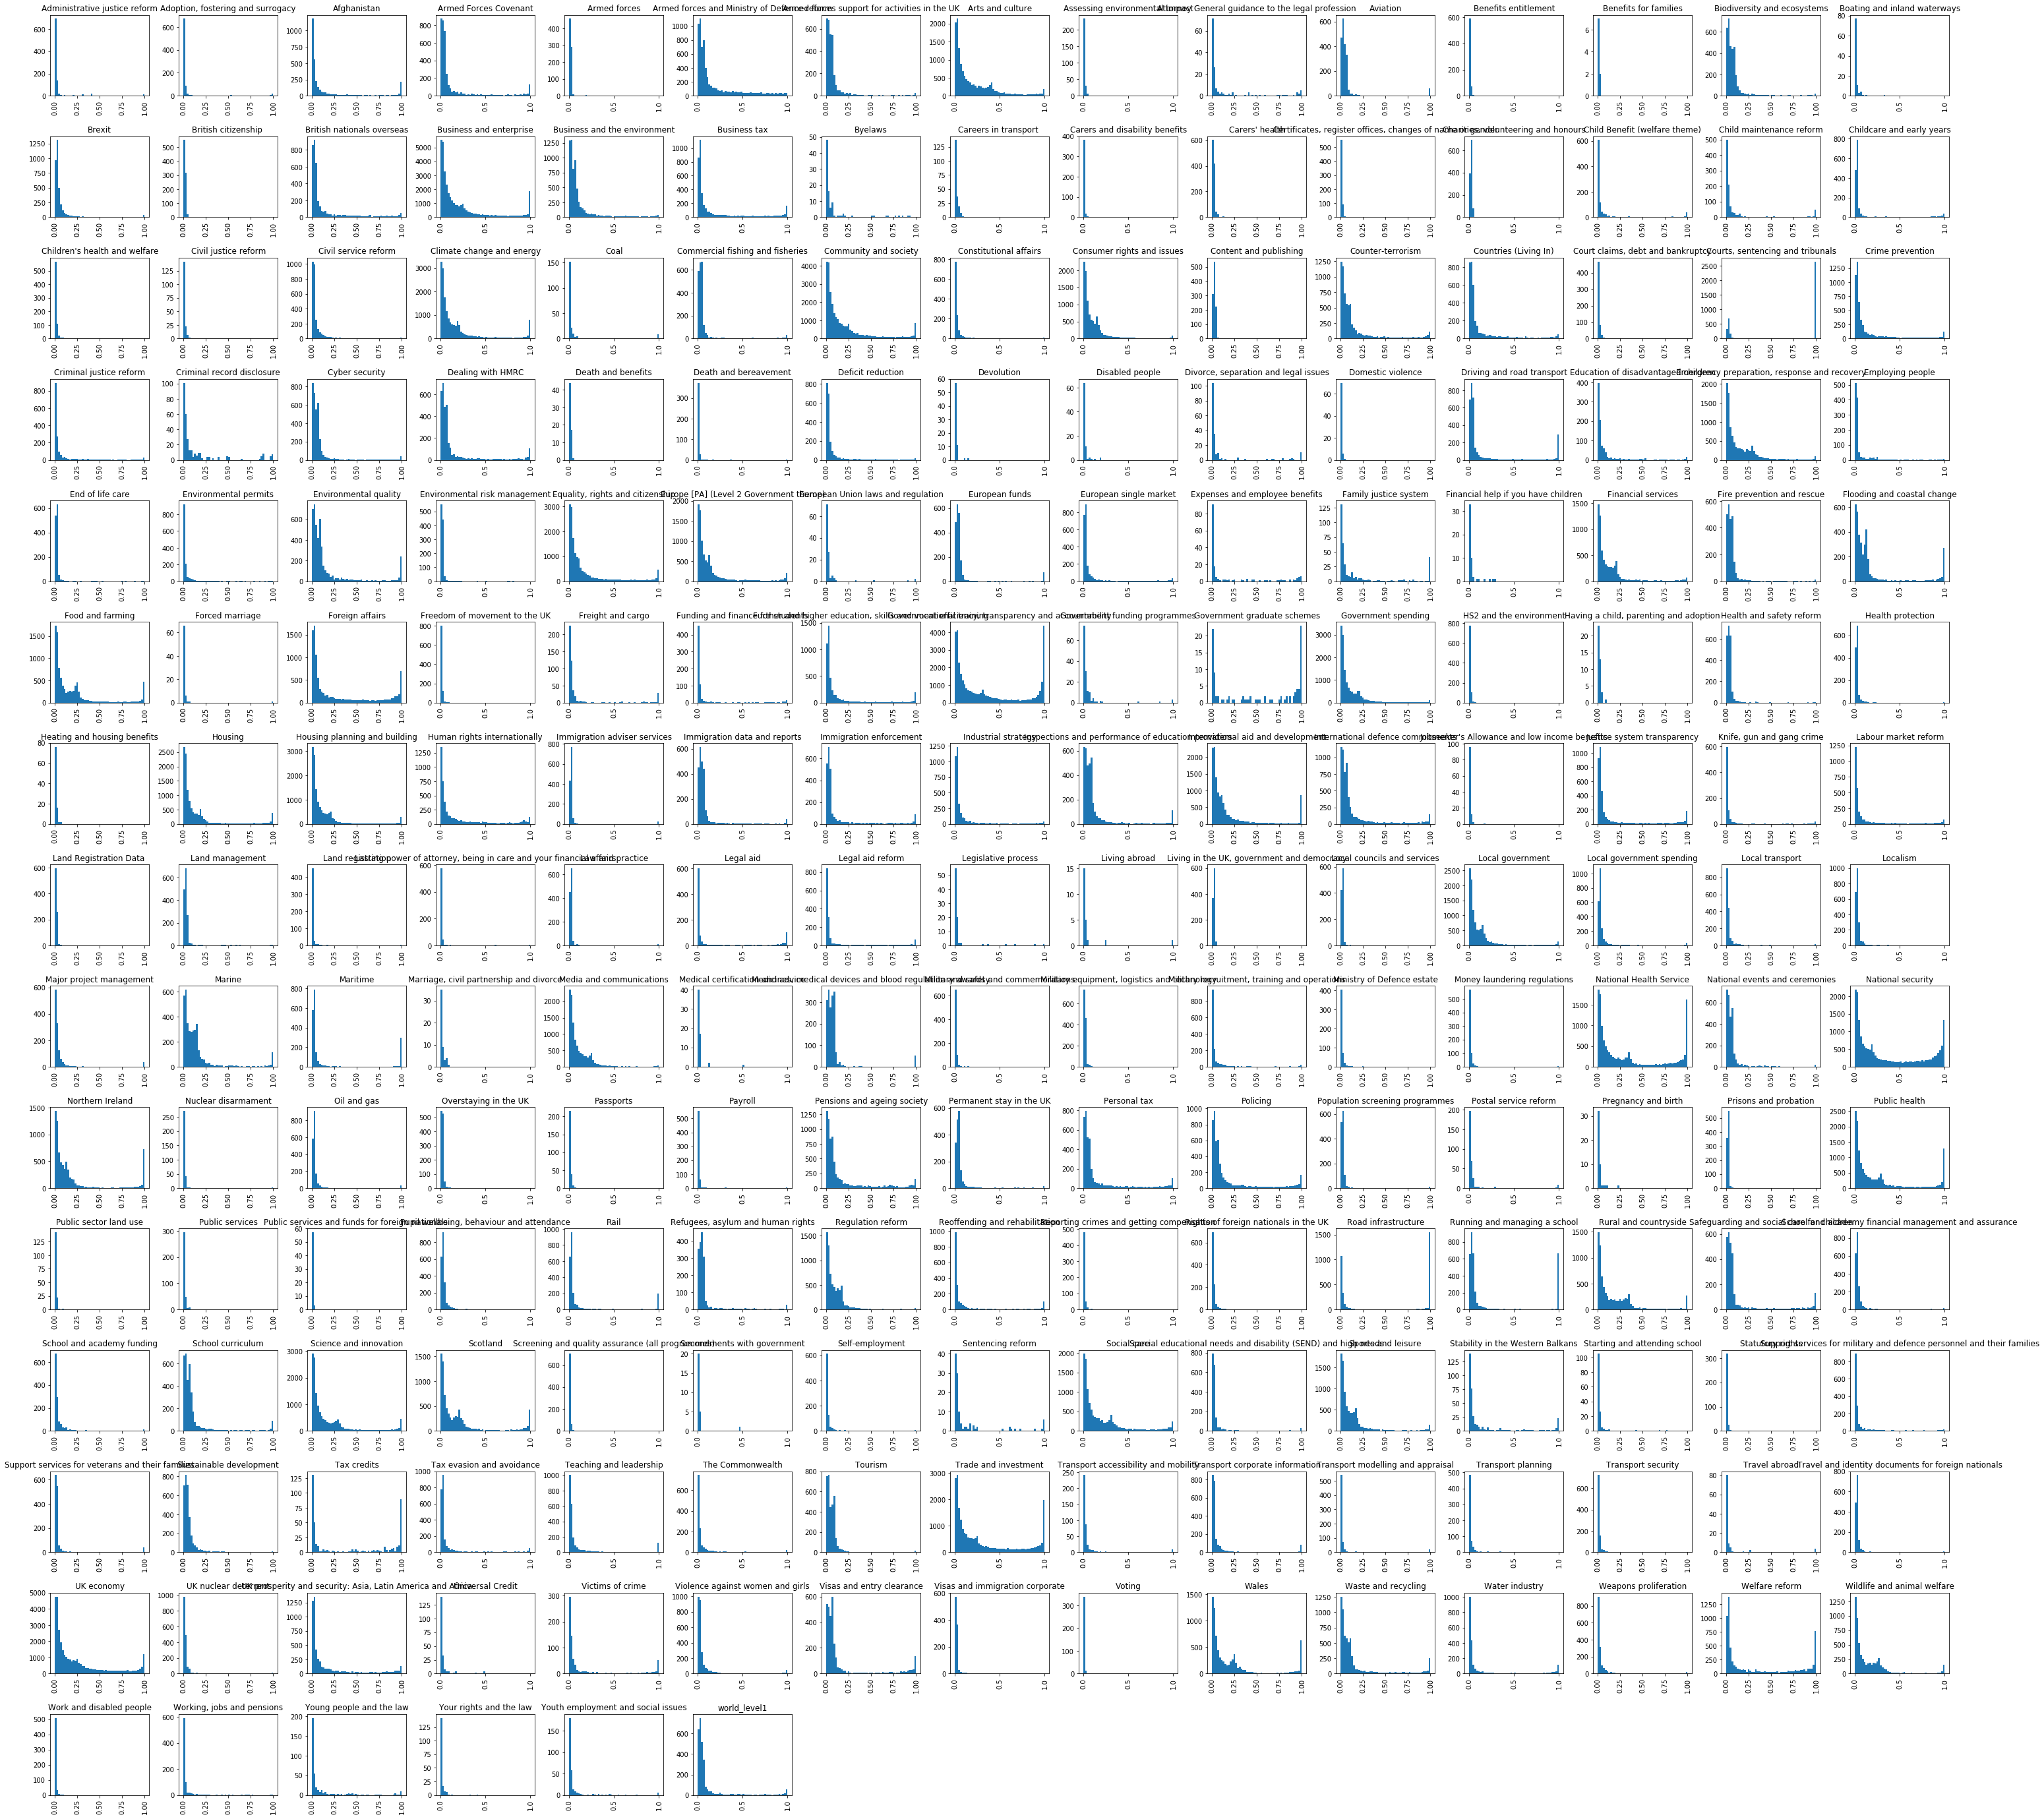

In [61]:
#TODO: work out how to standardise ylim to 0, 3000 
atleast1pct['prob'].hist(by=atleast1pct['taxon2label'], range=(0, 1), figsize=(50, 50), bins=50)

In [62]:
untagged_predictions = predictions[predictions['untagged_type']=='untagged']
oldtaxons_predictions = predictions[predictions['untagged_type']!='untagged']

In [63]:
untagged_predictions.groupby(['content_id']).size().sort_values(ascending=True).describe()

count    53269.000000
mean         1.386529
std          0.709352
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         11.000000
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2f57e73160>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f31e950cda0>]], dtype=object)

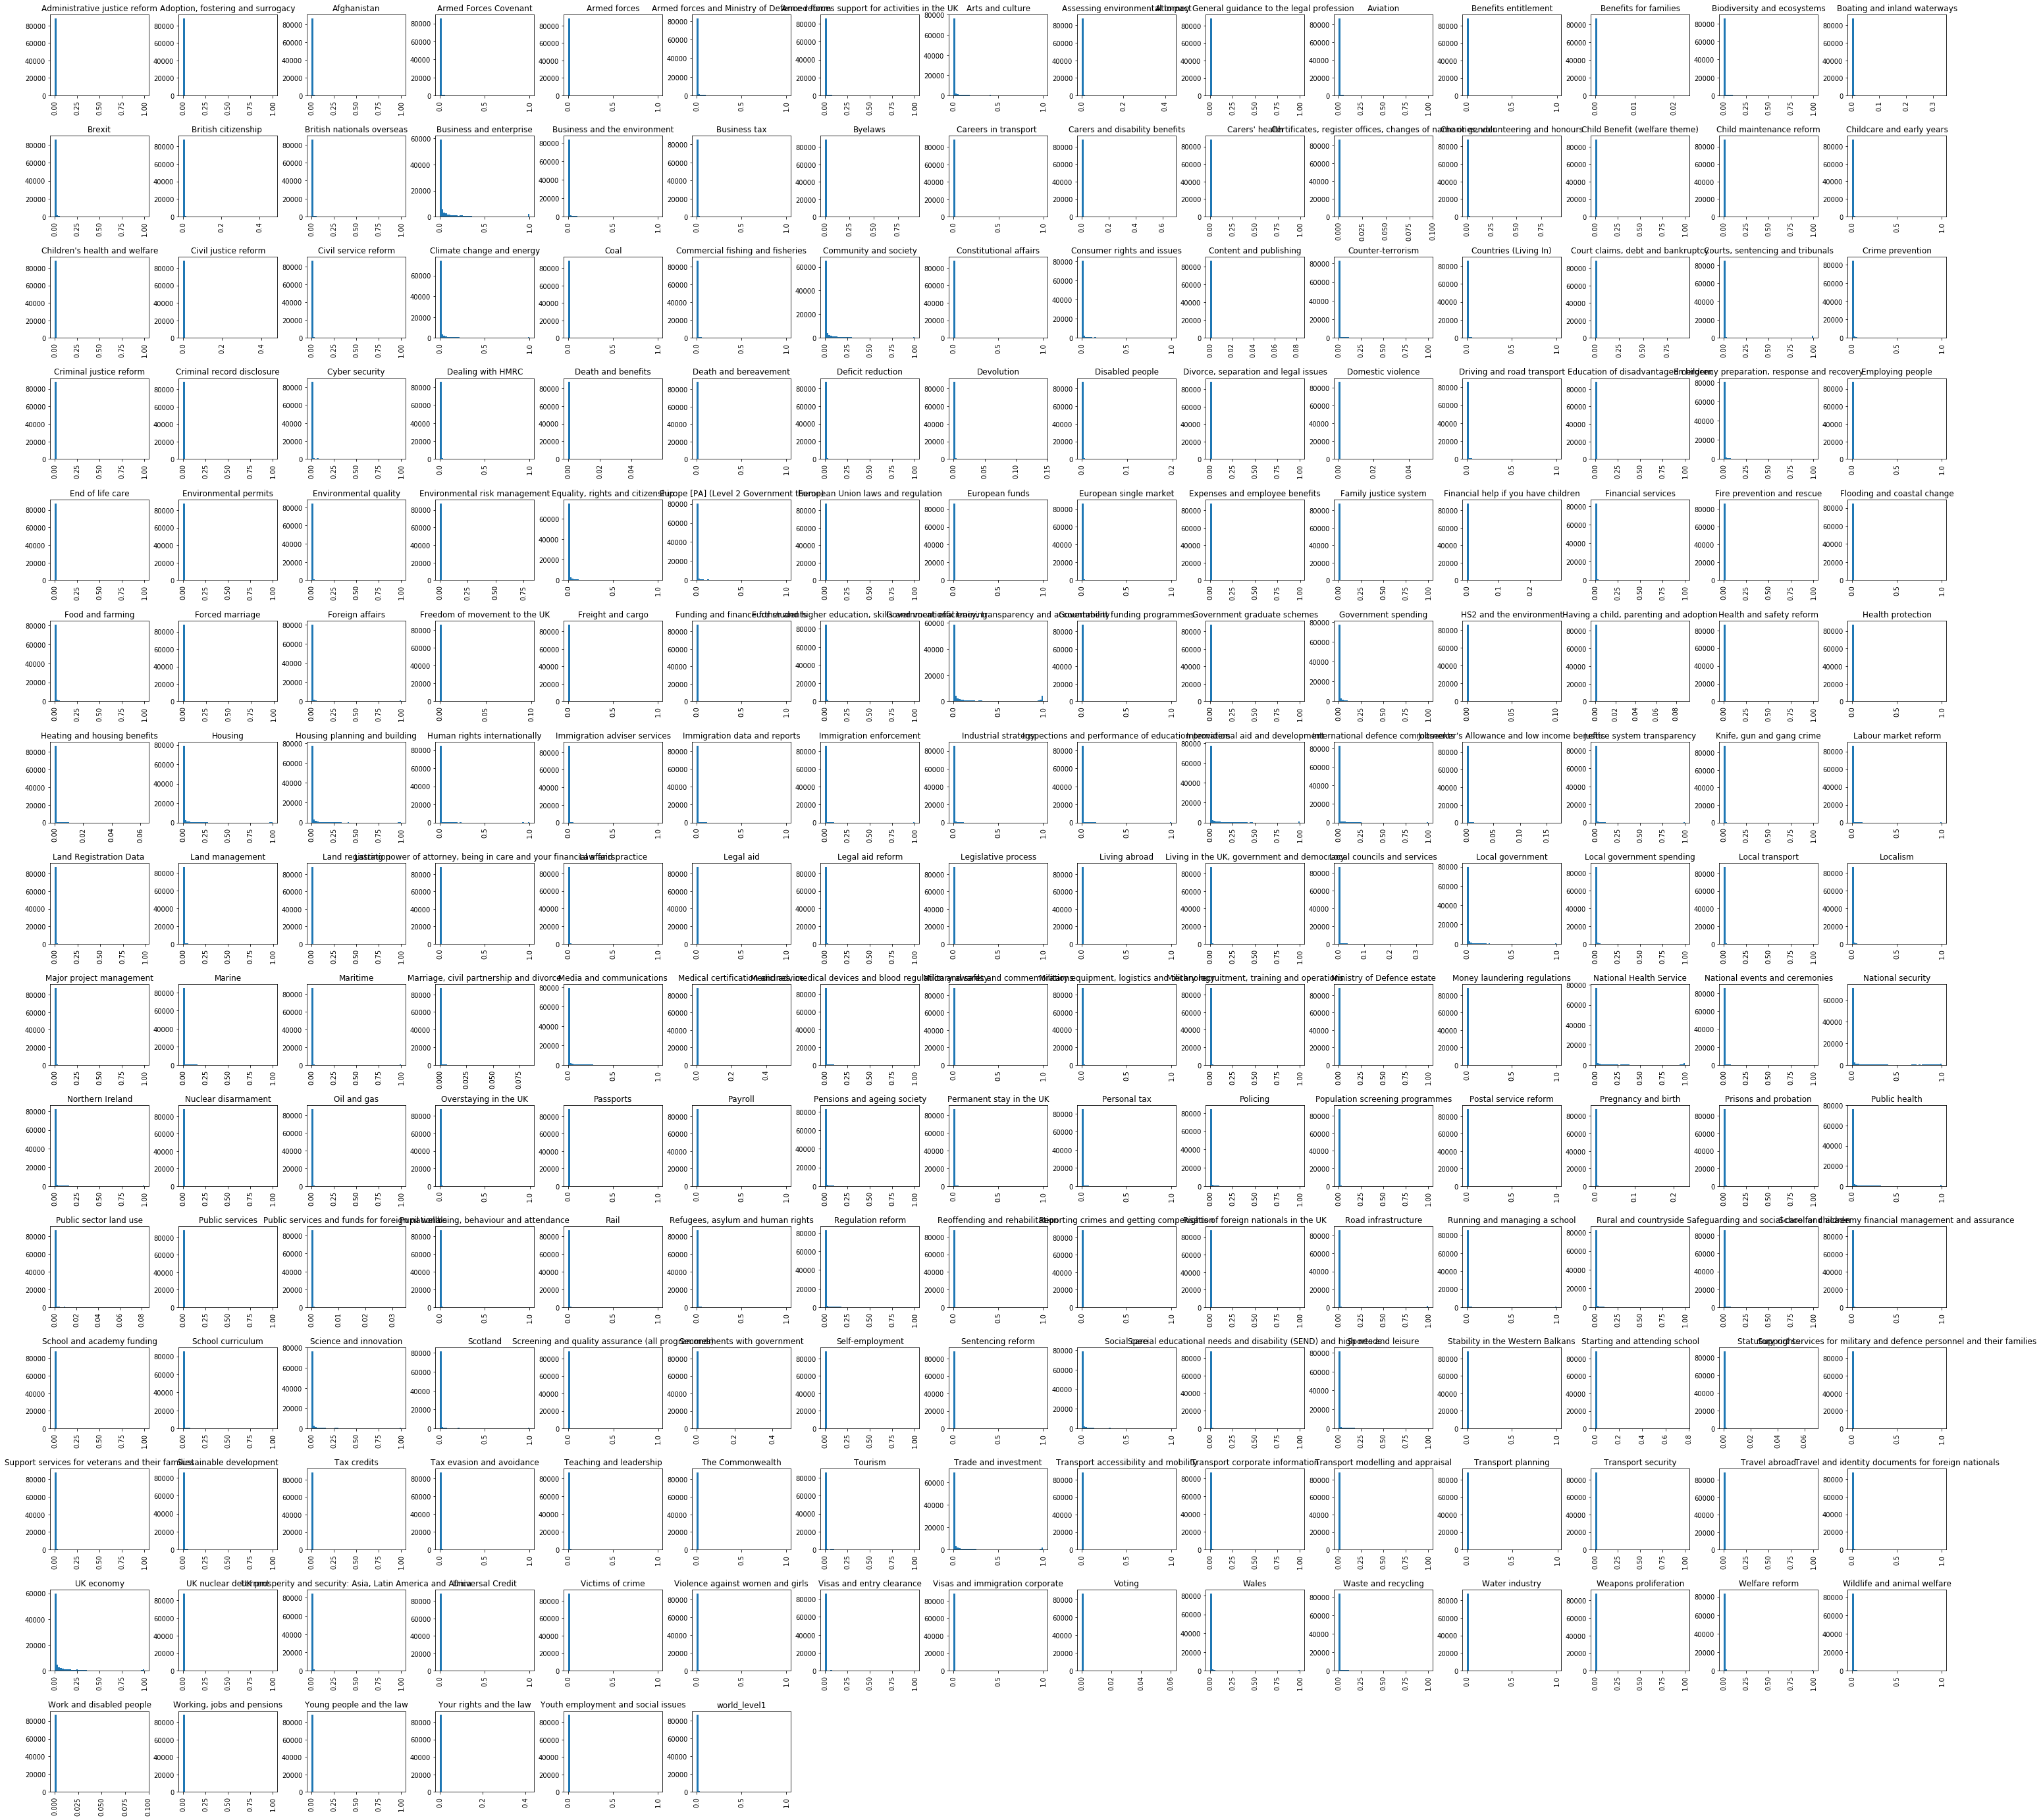

In [64]:
unlabelled_meta['prob'].hist(by=unlabelled_meta['taxon2label'], figsize=(50, 50), bins=50)

In [65]:
labelled_level2.groupby(['content_id']).size().sort_values(ascending=True).describe()

count    130208.000000
mean          1.391689
std           0.775747
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          35.000000
dtype: float64

In [66]:
oldtaxons_predictions.groupby(['content_id']).size().sort_values(ascending=True).describe()

count    13001.000000
mean         1.613799
std          1.470894
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         50.000000
dtype: float64

In [67]:
predictions.groupby(['content_id']).size().sort_values(ascending=True).describe()

count    66270.000000
mean         1.431115
std          0.914893
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         50.000000
dtype: float64

In [68]:
predictions[['base_path', 'taxon2label', 'title', 'description']][100:150]


,base_path,taxon2label,title,description
147235,/government/publications/children-in-care-and-...,"Adoption, fostering and surrogacy",children in care and adoption performance tabl...,information about the adoption and children's ...
147582,/government/publications/adoption-leadership-b...,"Adoption, fostering and surrogacy",adoption leadership board quarterly data repor...,reports on how adoption agencies are performin...
149271,/government/speeches/making-it-easier-for-more...,"Adoption, fostering and surrogacy",making it easier for more people to come forwa...,edward timpson speaks to local authorities and...
149911,/government/speeches/edward-timpson-addresses-...,"Adoption, fostering and surrogacy",edward timpson addresses the national fosterin...,edward timpson children’s minister announces n...
150201,/government/speeches/somebody-elses-child-in-a...,"Adoption, fostering and surrogacy",somebody else's child in a big society: how we...,tim loughton explains why all private fosterin...
150870,/government/policies/looked-after-children-and...,"Adoption, fostering and surrogacy",looked-after children and adoption,what the government’s doing about looked-after...
154348,/government/consultations/private-fostering-ar...,"Adoption, fostering and surrogacy",private fostering arrangement notifications: p...,we're seeking your views on plans to stop the ...
154403,/government/consultations/adoption-getting-it-...,"Adoption, fostering and surrogacy",adoption: getting it right making it work,proposed changes to adoption regulations and s...
160848,/government/publications/circular-maternity-pa...,"Adoption, fostering and surrogacy",circular 013/2013: maternity pay adoption pay ...,home office circular 013 / 2013 setting out ar...
176806,/government/news/deputy-british-ambassador-to-...,Afghanistan,deputy british ambassador to kabul twitter q&a...,deputy ambassador to kabul nic hailey will ans...


In [69]:
predictions[predictions['content_id']=='5c91ea82-7631-11e4-a3cb-005056011aef']


,content_id,prob,taxon2label,base_path,description,document_type,document_type_gp,first_published_at,level1taxon,locale,primary_publishing_organisation,publishing_app,taxon_id,title,untagged_type,updated_at,prob_cat
1519822,5c91ea82-7631-11e4-a3cb-005056011aef,0.888384,British nationals overseas,/government/news/post-tropical-cyclone-sandy,east coast of usa affected by winds rain snow ...,news_story,news_and_announcements,2012-10-31 00:00:00.000,NaN,en,Foreign & Commonwealth Office,whitehall,NaN,post-tropical cyclone sandy,untagged,2018-03-13 11:13:01.078,>=0.8
3638686,5c91ea82-7631-11e4-a3cb-005056011aef,0.770359,Countries (Living In),/government/news/post-tropical-cyclone-sandy,east coast of usa affected by winds rain snow ...,news_story,news_and_announcements,2012-10-31 00:00:00.000,NaN,en,Foreign & Commonwealth Office,whitehall,NaN,post-tropical cyclone sandy,untagged,2018-03-13 11:13:01.078,0.7-0.79


In [70]:
predictions[predictions['content_id']=='5d87c00c-7631-11e4-a3cb-005056011aef']


,content_id,prob,taxon2label,base_path,description,document_type,document_type_gp,first_published_at,level1taxon,locale,primary_publishing_organisation,publishing_app,taxon_id,title,untagged_type,updated_at,prob_cat
13181298,5d87c00c-7631-11e4-a3cb-005056011aef,0.986707,Public health,/government/news/government-launches-its-first...,the government’s first ever national cancer ca...,news_story,news_and_announcements,2012-01-30 00:00:00.000,NaN,en,Department of Health and Social Care,whitehall,NaN,government launches its first ever national bo...,untagged,2018-01-10 15:13:52.931,>=0.8


In [71]:
predictions[['base_path', 'taxon2label', 'title', 'description']].to_csv(os.path.join(DATADIR, 'new_predictions50.csv.gz'),compression='gzip',index=False)

In [72]:
taxons = predictions['taxon2label'].unique()
subsample = pd.DataFrame(columns = predictions.columns)

for taxon in taxons:
    taxon_spec = predictions.loc[predictions['taxon2label']==taxon]
    sample_size = int(round(taxon_spec.shape[0]*0.1))
    if not sample_size == 0 and taxon_spec.shape[0] > sample_size:
        print(taxon,": SAMPLING AT:",sample_size)
        subsample = subsample.append(taxon_spec.sample(n=sample_size), ignore_index=True)

Administrative justice reform : SAMPLING AT: 4
Adoption, fostering and surrogacy : SAMPLING AT: 7
Afghanistan : SAMPLING AT: 46
Armed Forces Covenant : SAMPLING AT: 41
Armed forces : SAMPLING AT: 1
Armed forces and Ministry of Defence reform : SAMPLING AT: 97
Armed forces support for activities in the UK : SAMPLING AT: 13
Arts and culture : SAMPLING AT: 143
Attorney General guidance to the legal profession : SAMPLING AT: 2
Aviation : SAMPLING AT: 10
Biodiversity and ecosystems : SAMPLING AT: 11
Brexit : SAMPLING AT: 13
British nationals overseas : SAMPLING AT: 37
Business and enterprise : SAMPLING AT: 488
Business and the environment : SAMPLING AT: 38
Business tax : SAMPLING AT: 60
Byelaws : SAMPLING AT: 1
Carers' health : SAMPLING AT: 2
Child Benefit (welfare theme) : SAMPLING AT: 7
Child maintenance reform : SAMPLING AT: 10
Childcare and early years : SAMPLING AT: 13
Children's health and welfare : SAMPLING AT: 2
Civil service reform : SAMPLING AT: 8
Climate change and energy : SAMPL

In [73]:
subsample[['base_path', 'taxon2label', 'title', 'description']].to_csv(os.path.join(DATADIR, 'new_predictions_subsample.csv.gz'),compression='gzip',index=False)

### 40% threshold

In [74]:
predictions40 = newprob_meta[newprob_meta['prob'] > 0.4]

predictions40.content_id.nunique()

NameError: name 'newprob_meta' is not defined

In [ ]:
predictions40.content_id.nunique()/newprob_meta.content_id.nunique()

In [ ]:
predictions40.groupby('untagged_type')['content_id'].nunique()

In [ ]:
who_ls

In [ ]:
reset_selective -f labelled_level2

In [ ]:
reset_selective -f highrisk_predictions

In [ ]:
reset_selective -f highrisk_predictions

### recency

In [ ]:
predictions['first_published_at'] = pd.to_datetime(predictions['first_published_at'])
predictions.index = predictions['first_published_at']

In [ ]:
predictions.sort_values(['prob', 'content_id'], ascending=False)

In [ ]:
predictions_dedup = predictions.drop_duplicates('content_id')
predicted = predictions_dedup['first_published_at'].resample('Y').count().plot()
predicted.set_xlim(pd.Timestamp('2000-12-31'), pd.Timestamp('2017-12-31'))
predicted.set_ylim([0, 30000])

In [ ]:
no_predictions['first_published_at_y'] = pd.to_datetime(no_predictions['first_published_at_y'])
no_predictions.index = no_predictions['first_published_at_y']

In [ ]:
no_predictions['content_id'].nunique()

In [ ]:
no_predictions.sort_values(['prob_y', 'content_id'], ascending=False)

In [ ]:
no_predictions_dedup = no_predictions.drop_duplicates('content_id')

In [ ]:
no_predictions_dedup.columns

In [ ]:
cols =np.arange(1, 29)
cols

In [ ]:
hardtotag_guidance = no_predictions[no_predictions['document_type_y']=='guidance'].drop(no_predictions.columns[cols], axis=1 ).sort_values('prob_y')

In [ ]:
hardtotag_guidance.drop_duplicates('content_id', inplace=True)

In [ ]:
tagged_guidance = predictions[predictions['document_type']=='guidance']

In [ ]:
fig = plt.figure(figsize=(15, 7))
ax = hardtotag_guidance['first_published_at_y'].resample('Y').count().plot()
ax.set_xlim(pd.Timestamp('2000-12-31'), pd.Timestamp('2018-03-12'))


In [ ]:
fig = plt.figure(figsize=(15, 7))
ay = tagged_guidance['first_published_at'].resample('Y').count().plot()
ay.set_xlim(pd.Timestamp('2000-12-31'), pd.Timestamp('2018-03-12'))

In [ ]:
hardtotag_guidance[['content_id', 'title_y', 'description_y', 'body_y', 'prob_y', 'taxon2label_y' ]].to_csv(os.path.join(DATADIR, 'hardtotag_guidance.csv.gz'), compression='gzip')

In [ ]:
not_predicted = no_predictions_dedup['first_published_at_y'].resample('Y').count().plot()
not_predicted.set_xlim(pd.Timestamp('2000-12-31'), pd.Timestamp('2017-12-31'))

In [ ]:

fig = plt.figure(figsize=(15, 7))

plt.subplot(2, 1, 1)
plt.title('predictions at 50% threshold')
predicted = predictions_dedup['first_published_at'].resample('Y').count().plot()
predicted.set_xlim(pd.Timestamp('2000-12-31'), pd.Timestamp('2018-03-12'))
predicted.set_ylim([0, 10000])
predicted.axes.get_xaxis().set_ticklabels([])
predicted.set_xlabel('')

plt.subplot(2, 1, 2)
not_predicted = no_predictions_dedup['first_published_at_y'].resample('Y').count().plot()
not_predicted.set_xlim(pd.Timestamp('2000-12-31'), pd.Timestamp('2018-03-12'))
plt.title('No predictions above 50%')
plt.ylabel('Count')
not_predicted.set_ylim([0, 10000])






fig.tight_layout()

In [ ]:

doctype_grouped = predictions_dedup.groupby(['document_type', pd.Grouper(freq='Y')])['first_published_at'].count()
count_by_year = doctype_grouped.unstack('document_type', fill_value=0)

In [ ]:
top_count = count_by_year.loc[:,count_by_year.max() > 500]
ax = top_count.plot()
ax.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2018-03-12'))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
lab = count_by_year.stack().reset_index()
lab.columns = ['date', 'document_type', 'percent']
bydoctype_year = lab.groupby(['date', 'document_type']).agg({'percent': 'sum'})
# Change: groupby state_office and divide by sum
bydoctype_pcts = bydoctype_year.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).unstack('document_type', fill_value=0)

bydoctype_pcts.columns = bydoctype_pcts.columns.droplevel(0)

top_pct = bydoctype_pcts[['organisation', 
                          'person', 
                          'placeholder_person', 
                          'regulation', 
                          'world_news_story', 
                          'news_story', 
                          'foi_release',
                          'guidance',
                          'national_statistics',
                          'official_statistics', 
                          'press_release',
                          'transparency'
 ]]

In [ ]:
ut = top_pct.plot(kind='area', stacked=True)
ut.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2018-03-12'))
ut.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
doctype_grouped = no_predictions_dedup.groupby(['document_type_y', pd.Grouper(freq='Y')])['first_published_at_y'].count()
count_by_year = doctype_grouped.unstack('document_type_y', fill_value=0)

top_count = count_by_year.loc[:,count_by_year.max() > 300]
ax = top_count.plot()
ax.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2018-03-12'))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
ax = predictions_dedup['first_published_at'].resample('Y').count().plot()
ax.set_xlim(pd.Timestamp('2000-12-31'), pd.Timestamp('2018-03-12'))

In [ ]:
lab = count_by_year.stack().reset_index()
lab.columns = ['date', 'document_type', 'percent']
bydoctype_year = lab.groupby(['date', 'document_type']).agg({'percent': 'sum'})
# Change: groupby state_office and divide by sum
bydoctype_pcts = bydoctype_year.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).unstack('document_type', fill_value=0)

bydoctype_pcts.columns = bydoctype_pcts.columns.droplevel(0)

top_pct = bydoctype_pcts[['organisation', 
                          'person', 
                          'placeholder_person', 
                          'regulation', 
                          'world_news_story', 
                          'news_story', 
                          'foi_release',
                          'guidance',
                          'national_statistics',
                          'official_statistics', 
                          'press_release',
                          'transparency'
 ]]



In [ ]:
ut = top_pct.plot(kind='area', stacked=True)
ut.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2018-03-12'))
ut.legend(loc='center left', bbox_to_anchor=(1, 0.5))